In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import json

In [ ]:
file_path = "data_full.json"

with open(file_path, "r") as file:
    data = json.load(file)


train_data = []
for item in data['train']:
    train_data.append({'text': item[0], 'intent': item[1]})

test_data = []
for item in data['test']:
    test_data.append({'text': item[0], 'intent': item[1]})

val_data = []
for item in data['val']:
    val_data.append({'text': item[0], 'intent': item[1]})

# Convert to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)


# Combine train and validation sets
train_df = pd.concat([train_df, val_df]).reset_index(drop=True)

print(len(train_df))
print(len(test_df))

18000
4500


In [ ]:
print(train_df['intent'].unique().shape)

(150,)


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Prepare Features and Labels
x_train = train_df['text']
y_train = train_df['intent']

x_test = test_df['text']
y_test = test_df['intent']

x_val = val_df['text']
y_val = val_df['intent']

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(x_train))

# Convert text to sequence
x_train_seq = tokenizer.texts_to_sequences(list(x_train))
x_test_seq = tokenizer.texts_to_sequences(list(x_test))
x_val_seq = tokenizer.texts_to_sequences(list(x_val))

# Calculate maximum sequence length
X_seq_len = [len(x) for x in x_train_seq]
X_test_seq_len = [len(x) for x in x_test_seq]
X_val_seq_len = [len(x) for x in x_val_seq]
max_len = max(max(X_seq_len), max(max(X_test_seq_len), max(X_val_seq_len)))

# Pad sequences
X = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
X_test = pad_sequences(x_test_seq, maxlen=max_len, padding='post')
X_val = pad_sequences(x_val_seq, maxlen=max_len, padding='post')

# Label Encoding for outputs
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# One-Hot Encoding
y_train_encoded = utils.to_categorical(y_train_encoded)
y_test_encoded = utils.to_categorical(y_test_encoded)
y_val_encoded = utils.to_categorical(y_val_encoded)
print(y_train_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
y_train_encoded[0].shape

(150,)

In [ ]:
# Model parameters
VAL_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_DIM = 100
NUM_UNITS = 64
NUM_CLASSES = 150
VOCAB_SIZE = len(tokenizer.word_index) + 1

# Define the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE,
             output_dim=EMBEDDING_DIM,
             input_length=max_len,
             mask_zero=True),
    LSTM(NUM_UNITS, activation='relu', return_sequences=True),
    LSTM(NUM_UNITS, activation='relu'),
    Dense(NUM_UNITS, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the Model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',Precision(),Recall()]
)

In [ ]:
# Train the model
history = lstm_model.fit(
    X, y_train_encoded,
    validation_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.0459 - loss: 4.6414 - precision_6: 0.3913 - recall_6: 0.0073 - val_accuracy: 0.3456 - val_loss: 2.5573 - val_precision_6: 0.6067 - val_recall_6: 0.1200
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.5217 - loss: 1.7970 - precision_6: 0.8130 - recall_6: 0.3034 - val_accuracy: 0.6872 - val_loss: 1.3052 - val_precision_6: 0.8603 - val_recall_6: 0.5611
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7942 - loss: 0.7872 - precision_6: 0.8956 - recall_6: 0.6860 - val_accuracy: 0.7450 - val_loss: 1.1417 - val_precision_6: 0.8518 - val_recall_6: 0.6800
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8797 - loss: 0.4584 - precision_6: 0.9351 - recall_6: 0.8271 - val_accuracy: 0.7467 - val_loss: 1.1746 - val_precision_6: 0.8317 - val_recall_6: 0.7028
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.9194 - loss: 0.3124 - precision_6: 0.9483 - recall_6

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = lstm_model.evaluate(X_test, y_test_encoded)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8083 - loss: 1.1836 - precision_6: 0.8486 - recall_6: 0.7900

Test Accuracy: 0.7989
Test Precision: 0.8370
Test Recall: 0.7838


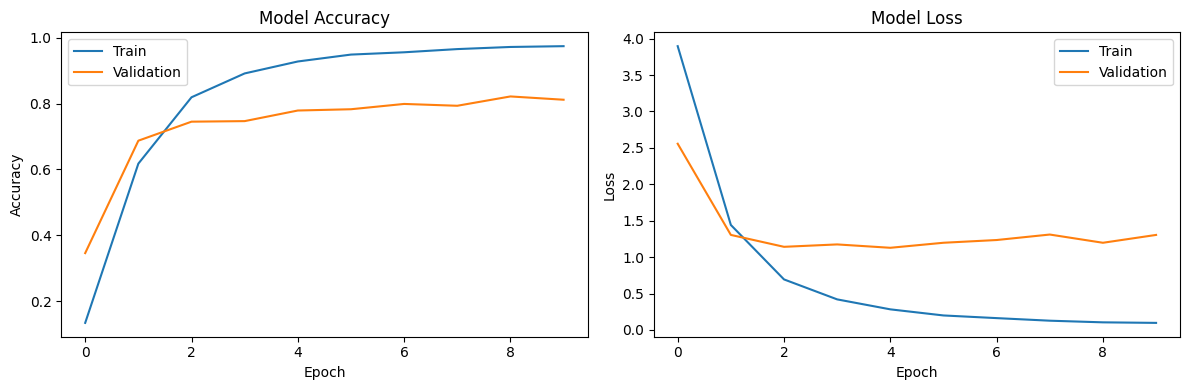

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# Function to make predictions
def predict_intent(text):
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Make prediction
    prediction = lstm_model.predict(padded)
    predicted_class = label_encoder.inverse_transform([prediction.argmax()])[0]

    return predicted_class

# Test the model with some example queries
test_queries = [
    "what time is it now?",
    "I need to book a hotel for tomorrow",
    "what's my insurance coverage?"
]

for query in test_queries:
    predicted_intent = predict_intent(query)
    print(f"\nQuery: {query}")
    print(f"Predicted Intent: {predicted_intent}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step

Query: what time is it now?
Predicted Intent: time
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Query: I need to book a hotel for tomorrow
Predicted Intent: book_hotel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Query: what's my insurance coverage?
Predicted Intent: insurance
